In [92]:
import numpy as np
import json
import h5py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib import mlab

In [93]:
event=['GW150914','GW151226','GW170104','LVT151012']

In [94]:
def smooth_gau(a,tau):
    aft=np.fft.rfft(a)
    x=np.linspace(0,1,len(a))
    gau=np.exp( -(x/tau)**2 )
    gau[-100::]=gau[100:0:-1]
    gauft=np.fft.rfft(gau/np.sum(gau))
    return abs( np.fft.irfft(aft*gauft,len(a)) )

In [95]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl
def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)
    
    
    dataFile.close()
    return strain,dt,utc,gpsStart

In [96]:
fnjson = "BBH_events_v3.json"
events = json.load(open(fnjson,"r"))

# a-b-c) Noise model, match fitting
Here, I will do the different tasks to find the GW inside the data.
I will first make a noise model for each of the Livingston and Hanford datasets.
To do so, I will window the strain (which is the data here), then I will FT the windowed strain. I will then take the square of that result and smooth it. The result of that process will be my noise model.
For the windowing, I used a Planck-taper window, that I built in this code. The window is flat on top, for an extended period, and has sides that depend on the given chosen value of epsilon. For the smoothing, I used a convolution with an extremely narrow gaussian. The different results I obtained convinced me that I did not need to take further step concerning the lines.
At the end of the next cell, I present the results I obtained on the 4 events. The results are really good on the Hanford in the first event, but are appreciably less good on the others dataset, which might be a sign that my noise model where not good enough, or that the templates used where a better fit for the first dataset than for the others.

The event is GW150914
The Hanford noise is :  0.1441377562322936
The Hanford SNR is :  17.804455920400926
The Livingston noise is : 0.13250527394034733
The Livingston SNR is :  12.65914903100167
The cumulative SNR is 21.84611418103023
The diffrerence in time is:  [0.00561528]


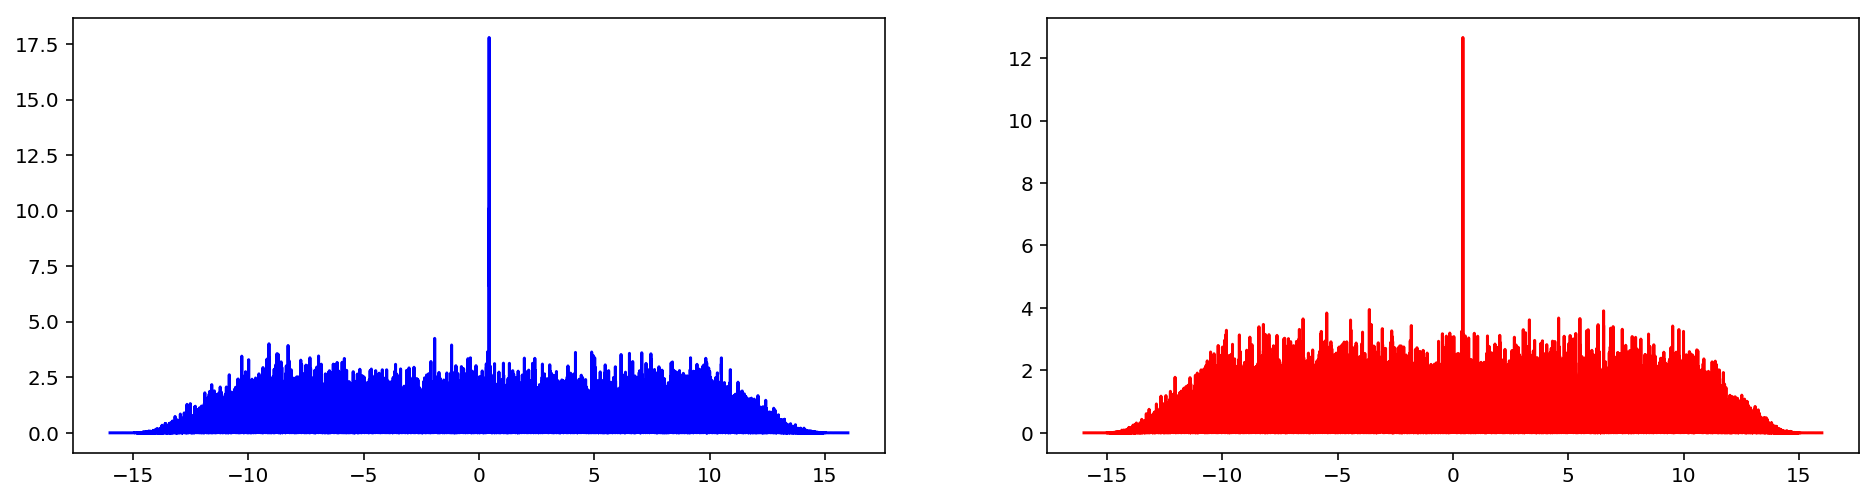

The event is GW151226
The Hanford noise is :  0.06419542760110422
The Hanford SNR is :  9.156778296857967
The Livingston noise is : 0.05001327661585334
The Livingston SNR is :  4.855941065307522
The cumulative SNR is 10.364687762183143
The diffrerence in time is:  [-0.00048828]


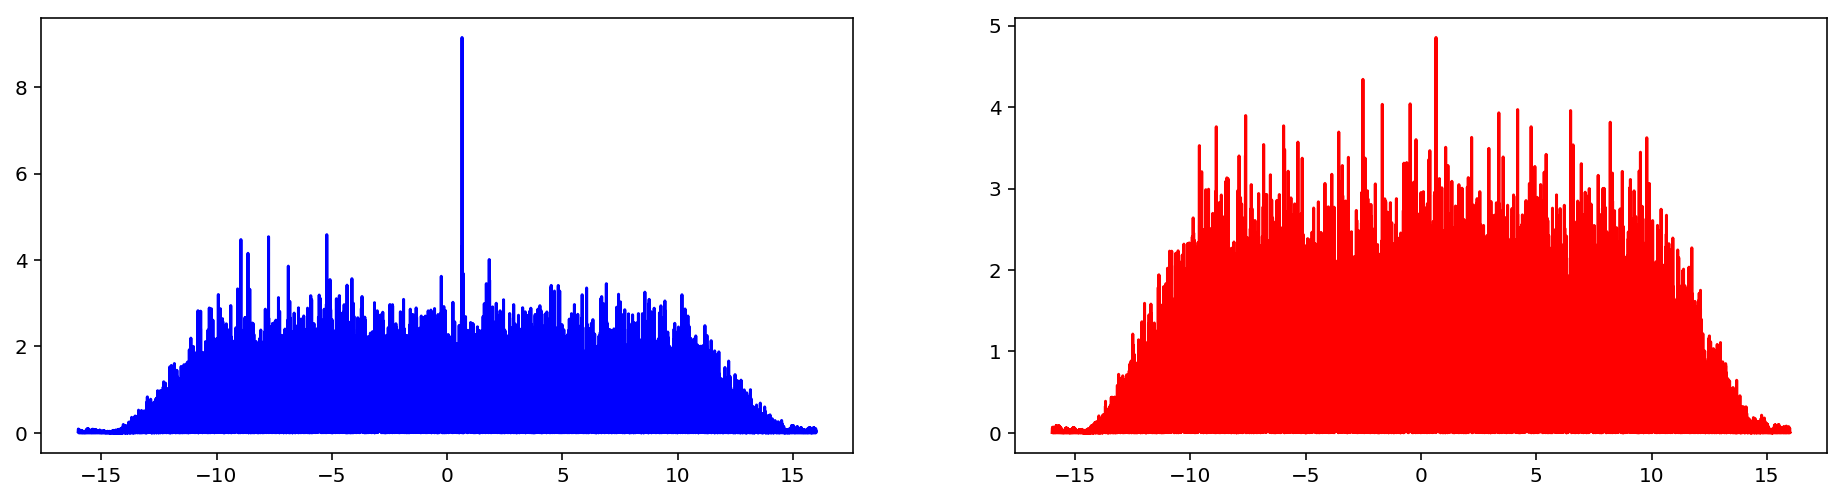

The event is GW170104
The Hanford noise is :  0.12058447344891955
The Hanford SNR is :  8.3603229415147
The Livingston noise is : 0.16265559988243378
The Livingston SNR is :  7.309319986835564
The cumulative SNR is 11.10500600433745
The diffrerence in time is:  [23.82879508]


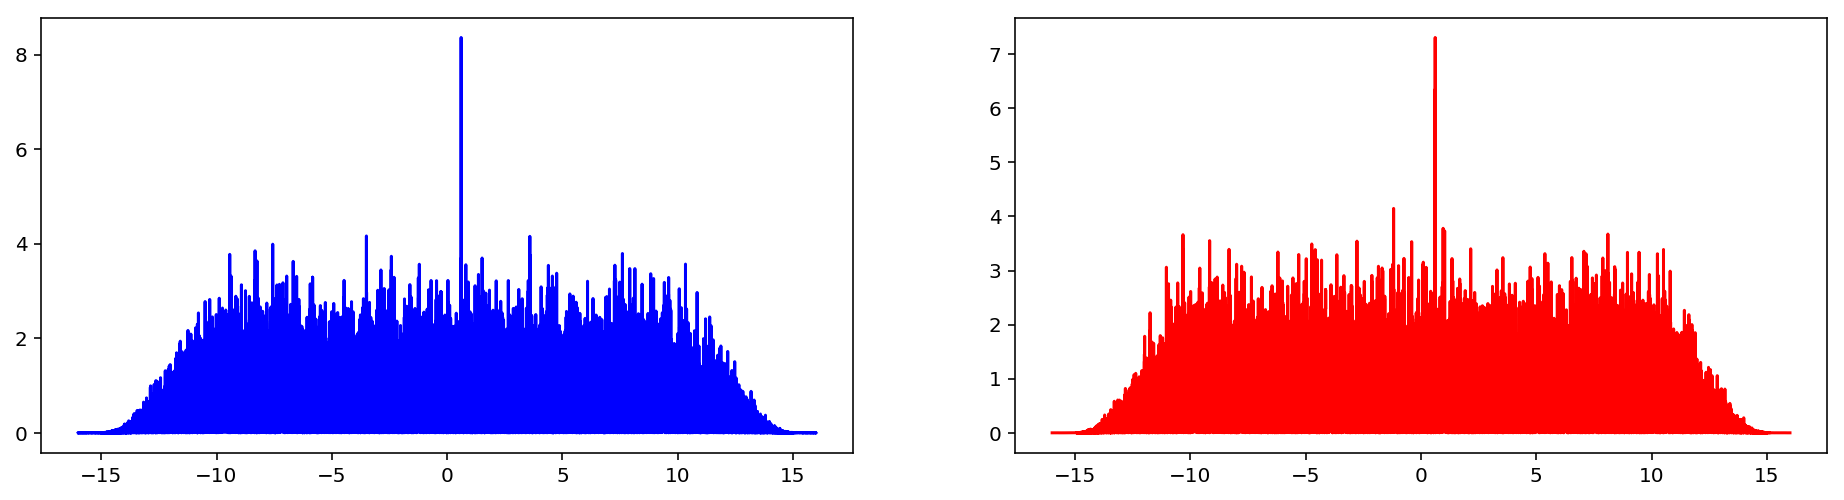

The event is LVT151012
The Hanford noise is :  0.09593007968501008
The Hanford SNR is :  6.717482763358216
The Livingston noise is : 0.09263366666796868
The Livingston SNR is :  5.579446101450451
The cumulative SNR is 8.73239906755328
The diffrerence in time is:  [-0.00195314]


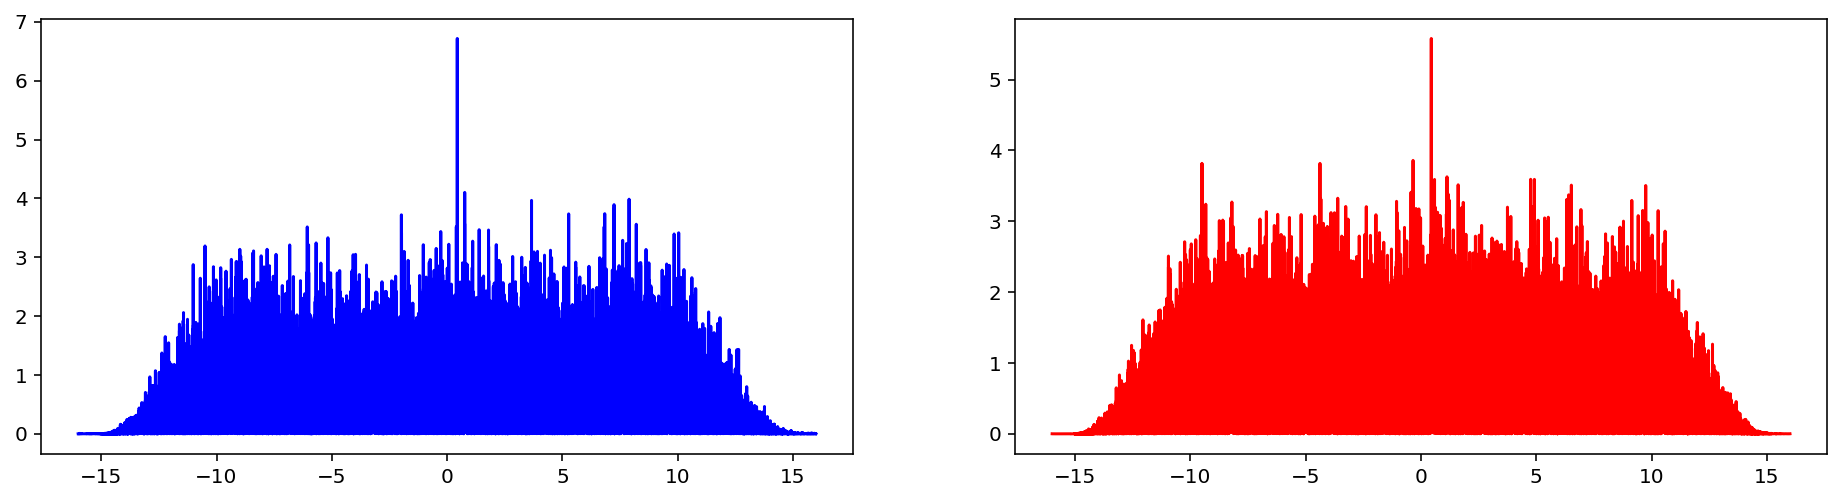

In [97]:
mfh=[]
mfl=[]
sigmah=[]
sigmal=[]
#Useful for question 4
freq_contr_h=[]
freq_contr_l=[]
for i in event:
    #Read hdf5 file
    fnames=[events[i]['fn_H1'],events[i]['fn_L1']]
    strains,dts,utcs,gpss=[],[],[],[]
    for j in fnames:
        fname=j
        #print('reading file ',j)
        strain,dt,utc,gps=read_file(j)
        strains.append(strain)
        dts.append(dt)
        utcs.append(utc)
        gpss.append(gps)
        
    #Read template
    template_name=events[i]['fn_template']
    th,tl=read_template(template_name)
    
    #Hanford and Livingston - data
    strain_H1=strains[0]
    strain_L1=strains[1]
    x_H1=np.linspace(0,dts[0]*len(strain_H1),len(strain_H1))
    x_L1=np.linspace(0,dts[1]*len(strain_L1),len(strain_L1))
    freq_H = np.fft.fftfreq(len(strain_H1),d=dts[0])
    freq_L = np.fft.fftfreq(len(strain_L1),d=dts[1])
    
    
    #window function (Planck-taper window)
    eps=0.25
    x1=np.linspace(0,len(strain_H1),len(strain_H1))
    ind11=np.where((x1 >= 1) & (x1 < eps*x1[-1]))
    ind12=np.where((x1 >= eps*x1[-1]) & (x1 <= (x1[-1]- eps*x1[-1]) ))
    ind13=np.where( (x1 <= x1[-1]-1) & (x1 > (x1[-1]- eps*x1[-1]) ) )
    w1=np.ones_like(x1)
    w1[ind11]=(1 + np.exp( (eps*x1[-1]/x1[ind11]) - (eps*x1[-1]/ (-x1[ind11] + eps*x1[-1]) ) ) )**-1
    #ind11=np.where((x1 >= 1) & (x1 < eps*x1[-1]))
    #ind12=np.where((x1 >= eps*x1[-1]) & (x1 <= (x1[-1]- eps*x1[-1]) ))
    #ind13=np.where( (x1 <= x1[-1]-1) & (x1 > (x1[-1]- eps*x1[-1]) ) )
    #w1[ind12]=1
    w1[ind13]=w1[ind11][::-1]
    w1[0]=0
    w1[-1]=0
    
    x2=np.linspace(0,len(strain_L1),len(strain_L1))
    ind21=np.where((x2 >= 1) & (x2 < eps*x2[-1]))
    ind22=np.where((x2 >= eps*x2[-1]) & (x2 <= (x2[-1]- eps*x2[-1]) ))
    ind23=np.where( (x2 <= x2[-1]-1) & (x2 > (x2[-1]- eps*x2[-1]) ) )
    w2=np.ones_like(x2)
    w2[ind21]=(1 + np.exp( (eps*x2[-1]/x2[ind21]) - (eps*x2[-1]/ (-x2[ind21] + eps*x2[-1]) ) ) )**-1
    #ind21=np.where((x2 >= 1) & (x2 < eps*x2[-1]))
    #ind22=np.where((x2 >= eps*x2[-1]) & (x2 <= (x2[-1]- eps*x2[-1]) ))
    #ind23=np.where( (x2 <= x2[-1]-1) & (x2 > (x2[-1]- eps*x2[-1]) ) )
    #w2[ind22]=1
    w2[ind23]=w1[ind21][::-1]
    w2[0]=0
    w2[-1]=0
    
    #Windowed model and data
    ps_H1=(np.fft.rfft(w1*strain_H1)) #windowed data
    ps_L1=(np.fft.rfft(w2*strain_L1))
    th_w=(np.fft.rfft(w1*th)) #windowed model ('Aft')
    tl_w=(np.fft.rfft(w2*tl)) #windowed model ('Aft')
    
    #frequency scale
    freq_H = np.fft.fftfreq(len(strain_H1),d=dts[0])
    freq_L = np.fft.fftfreq(len(strain_L1),d=dts[1])
    
    #Smoothed noise
    N_H=np.abs(ps_H1)**2 #Noise
    N_L=np.abs(ps_L1)**2  #Noise
#    SN_H=smooth_vec(N_H,5)
#    SN_L=smooth_vec(N_L,5)
    SN_H=smooth_gau(N_H,0.0005)
    SN_L=smooth_gau(N_L,0.0005)
    
    #To avoid overestimating the noise with the smoothin -- ignored
    #SN_H2=np.maximum(N_H,SN_H) #noise
    #SN_L2=np.maximum(N_L,SN_L) #noise
    
    #Whitening
    th_ft_whitened = th_w/(SN_H**0.5)
    th_whitened = np.fft.irfft(th_ft_whitened)
    ps_H_ft_whitened= ps_H1/SN_H**0.5
    ps_H_whitened= np.fft.irfft(ps_H_ft_whitened)
    sigma_h = np.sqrt(np.mean(th_whitened**2))
    
    tl_ft_whitened = tl_w/(SN_L**0.5)
    tl_whitened = np.fft.irfft(tl_ft_whitened)
    ps_L_ft_whitened= ps_L1/SN_L**0.5
    ps_L_whitened= np.fft.irfft(ps_L_ft_whitened)   
    sigma_l= np.sqrt(np.mean(tl_whitened**2))
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs = 4096, NFFT = 32*4096)
    
    
    #Match fitting with np.maximum, no prewhitening -- ignored
#    mf_ft1=np.conj(th_w1)*(ps_H1/SN_H2)
#    mf1=(np.fft.irfft(mf_ft1))
#    mf_ft2=np.conj(th_w2)*(ps_L1/SN_L2)
#    mf2=(np.fft.irfft(mf_ft2))
#    mfh.append(mf1)
#    mfl.append(mf2)
        
    #Match fitting, no np.maximum, no prewhitening -- ignored
    #mf_ft_h=np.conj(th_w)*(ps_H1/SN_H) 
    #mf_h=(np.fft.irfft(mf_ft_h))  #cross correlation
    #mf_ft_l=np.conj(tl_w)*(ps_L1/SN_L)
    #mf_l=(np.fft.irfft(mf_ft_l)) #cross correlation
    
    #Match fitting with whitening no np.maximum
    mf_ft_h=np.conj(th_ft_whitened)*(ps_H_ft_whitened) 
    mf_h=(np.fft.irfft(mf_ft_h))  #cross correlation
    
    mf_ft_l=np.conj(tl_ft_whitened)*(ps_L_ft_whitened)
    mf_l=(np.fft.irfft(mf_ft_l)) #cross correlation
    
    snr_h=np.max(abs(mf_h))/np.std(mf_h[3000:40000])
    noise_est_h=np.std(mf_h[3000:40000])
    print('The event is '+i)
    print('The Hanford noise is : ', noise_est_h)
    print('The Hanford SNR is : ', snr_h )
    snr_l=np.max(abs(mf_l))/np.std(mf_l[3000:40000])
    noise_est_l=np.std(mf_l[3000:40000])
    print('The Livingston noise is :', noise_est_l)
    print('The Livingston SNR is : ', snr_l )
    print('The cumulative SNR is', np.sqrt(snr_l**2 +snr_h**2))
    delt=x_H1[np.where(mf_h==mf_h.max())]-x_L1[np.where(mf_l==mf_l.max())]
    print('The diffrerence in time is: ', delt )
    
    freq_contr_h.append(abs((th_ft_whitened))**2)
    freq_contr_l.append(abs(tl_ft_whitened)**2) 
    sigmah.append(sigma_h)
    sigmal.append(sigma_l)
    mfh.append(mf1)
    mfl.append(mf2)
    
    figure,axes= plt.subplots(1,2,figsize=(16,4))
    axes[0].plot(x_H1-x_H1.max()/2,abs(np.fft.fftshift(mf_h))/noise_est_h,'b')
    axes[1].plot(x_L1-x_L1.max()/2,abs(np.fft.fftshift(mf_l))/noise_est_l,'r')
    plt.show()

# d) Analytical values of noise
In the cell below, I computed the analytical values for the noise. The values are slightly different from what I obtained previously. I can think of only one reason for that slight difference I previously computed the SNR value using chunks of the data that I selected, while this analytical version uses all the values

In [101]:
for i in range(len(sigmah)):
    print('The analytical Hanford noise for the event '+ event[i]+ ' is:', sigmah[i] )
    print('The analytical Livingston noise for the event '+ event[i]+' is:', sigmah[i] )

The analytical Hanford noise for the event GW150914 is: 0.12711592237434471
The analytical Livingston noise for the event GW150914 is: 0.12711592237434471
The analytical Hanford noise for the event GW151226 is: 0.05597850293107834
The analytical Livingston noise for the event GW151226 is: 0.05597850293107834
The analytical Hanford noise for the event GW170104 is: 0.10520544670663749
The analytical Livingston noise for the event GW170104 is: 0.10520544670663749
The analytical Hanford noise for the event LVT151012 is: 0.08188375579111777
The analytical Livingston noise for the event LVT151012 is: 0.08188375579111777


# e) Median frequency 
In the cell below, I find the frequency values above which the contribution to the event is the same as below. 
I used a cumulative sum on the square of the whitened template. That sum was normalized afterwards. Finding the point at which this cumulative sum become 0.5 gives us the frequency that we're looking for.

The median Hanford frequency for the event GW150914 is  110.84375 Hz
The median Livingstone frequency for the event GW150914 is  121.21875 Hz


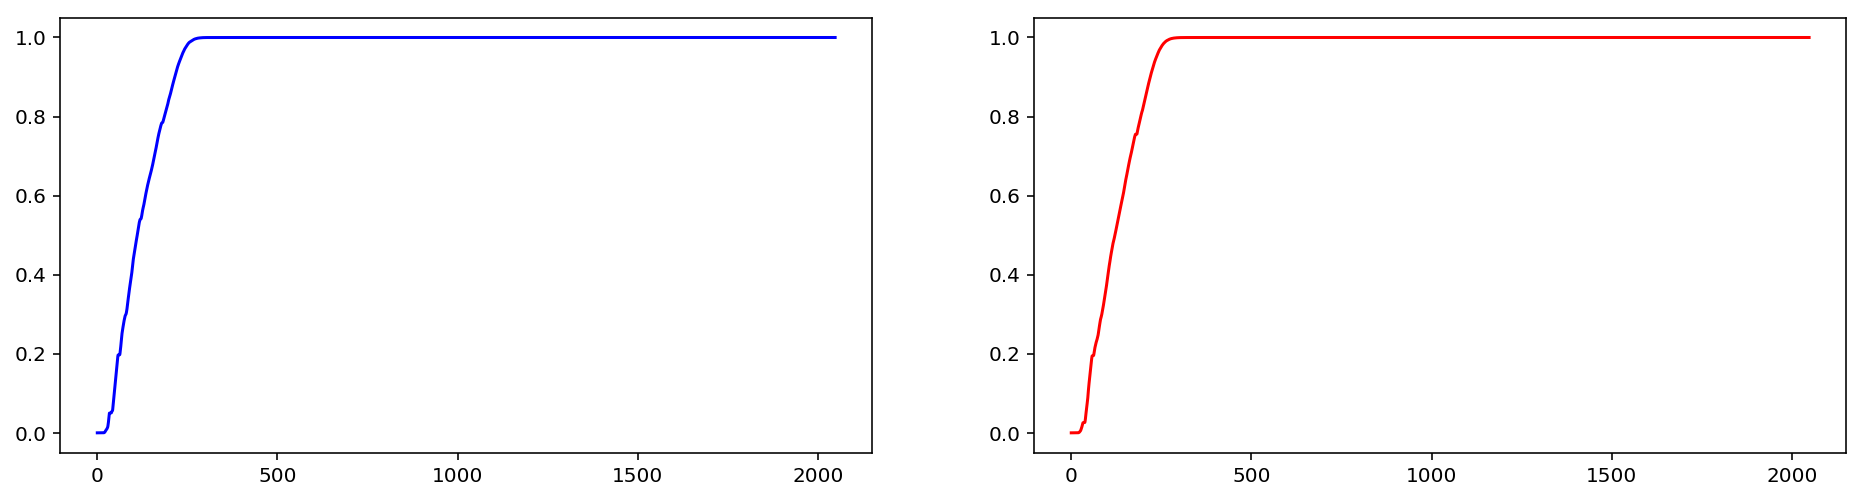

The median Hanford frequency for the event GW151226 is  87.125 Hz
The median Livingstone frequency for the event GW151226 is  109.40625 Hz


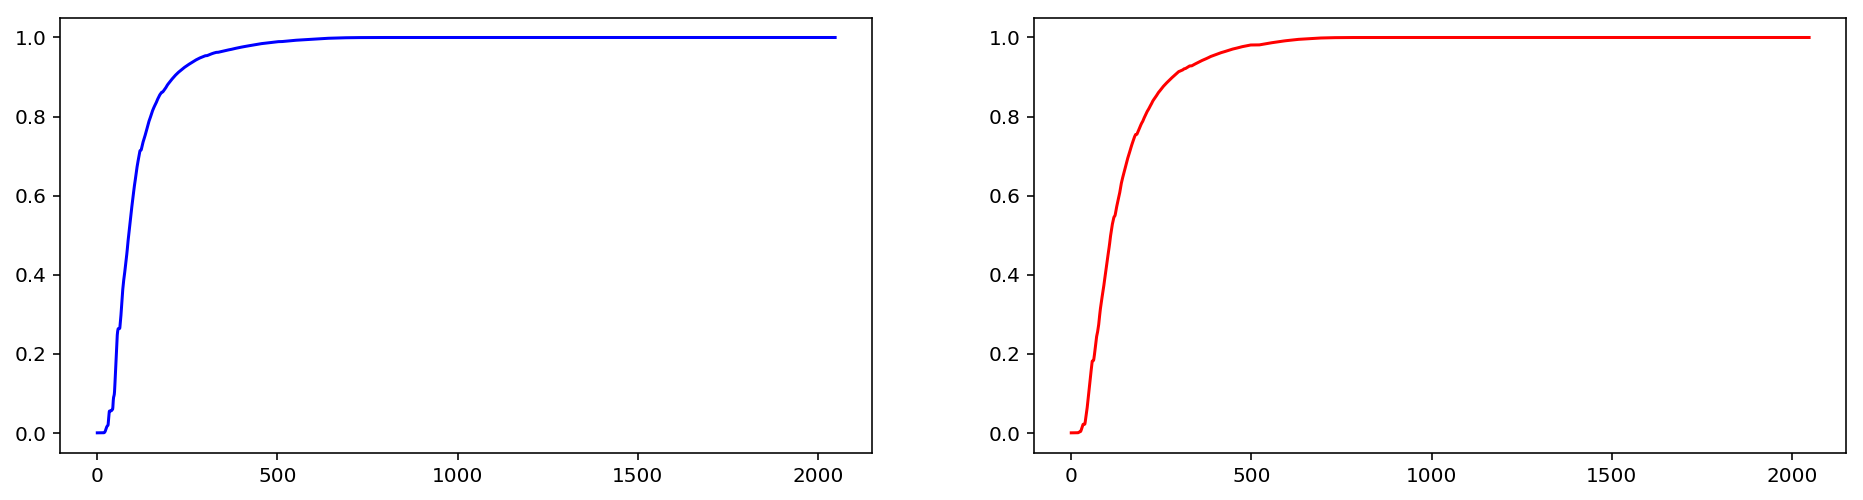

The median Hanford frequency for the event GW170104 is  102.84375 Hz
The median Livingstone frequency for the event GW170104 is  78.09375 Hz


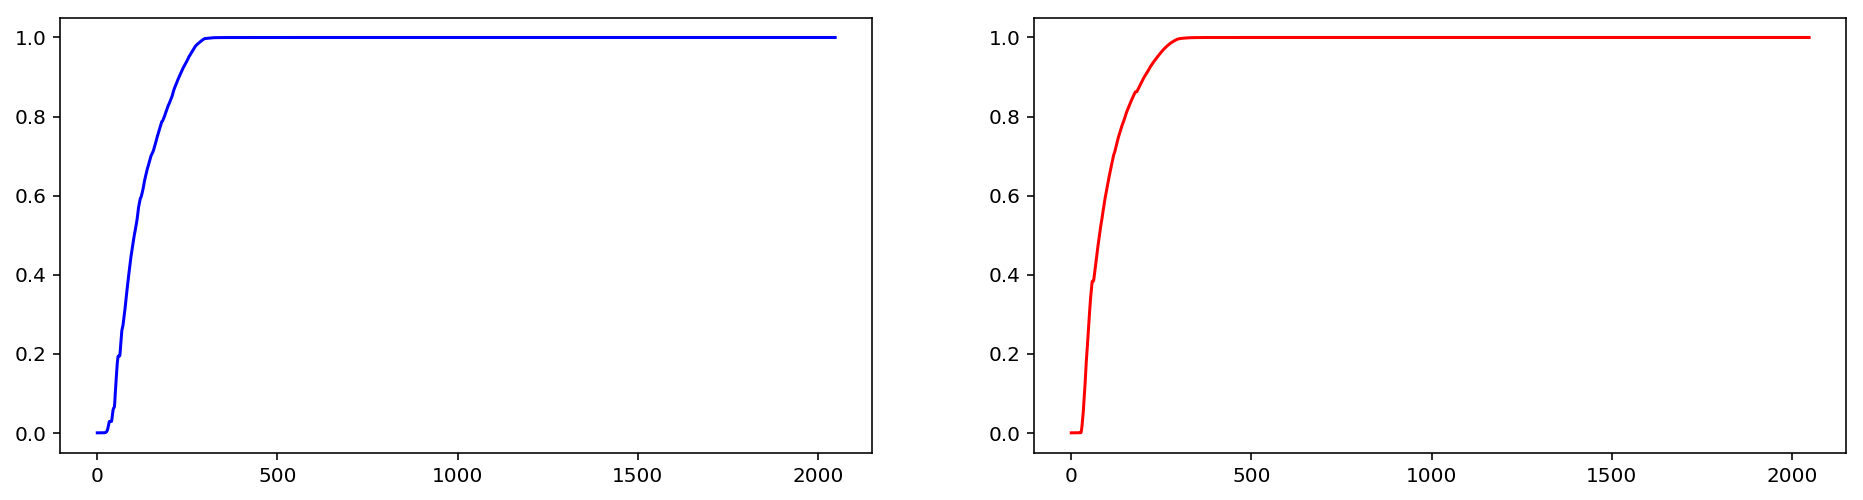

The median Hanford frequency for the event LVT151012 is  89.03125 Hz
The median Livingstone frequency for the event LVT151012 is  99.5 Hz


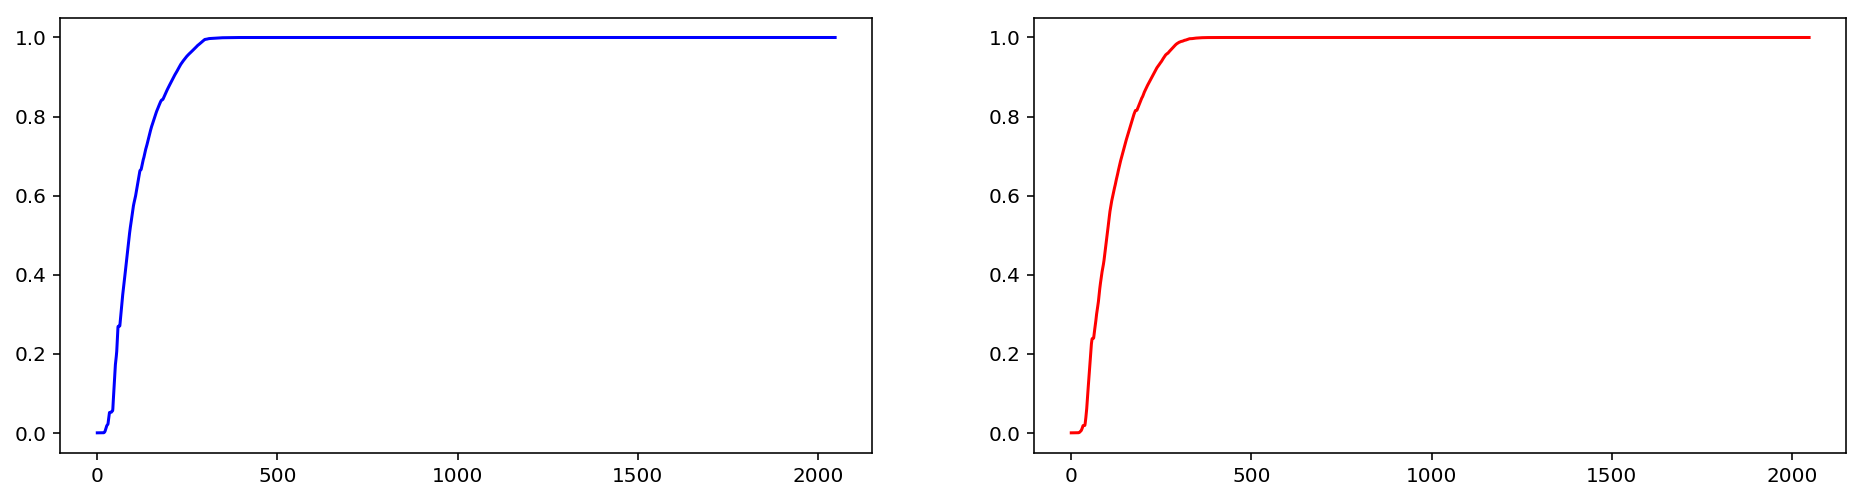

In [99]:
for i in range(len(freq_contr_h)):
    cur_contr_h=np.cumsum(freq_contr_h[i])
    norm_cum_h=cur_contr_h/cur_contr_h.max()
    cur_contr_l=np.cumsum(freq_contr_l[i])
    norm_cum_l=cur_contr_l/cur_contr_l.max()
    
    ind_med_h=np.where(norm_cum_h-0.5>=0)[0][0]
    ind_med_l=np.where(norm_cum_l-0.5>=0)[0][0]
    print('The median Hanford frequency for the event '+ event[i]+ ' is ', freq_H[ind_med_h],'Hz')
    print('The median Livingstone frequency for the event '+ event[i]+ ' is ', freq_L[ind_med_l],'Hz')
    
    figure,axes= plt.subplots(1,2,figsize=(16,4))
    axes[0].plot(freqs,norm_cum_h,'b')
    axes[1].plot(freqs,norm_cum_l,'r')
    plt.show()

# f) Estimation of the position 
Using Fig-2.1 from http://www.astro.puc.cl/~rparra/tools/ASTRONOMY/node2.html, we can deduce the order of magnitutde of the angle theta, as well as the uncertainty.
From the data that we have, we can find the difference between the time of arrival, down to 10^(-8)s. It often is to the order of 10^(-4)s, as we can see from above.
The theta angle is the same as the small angle made by side B and D and l is c times delta_t with delta t the difference in the times of arrival and c the speed of light.
Then the sine of theta is just (l/D) with D the distance between the two stations. We can do a taylor expansion of the sine of theta, and keep the first term (theta). Then theta= l/D. With c of the order of 10^(8), delta_t of the order of 10^(-4) and D of the order of 10^(6), we have a theta of the order of 10^(-2), with the first truncated term of that order cubed: 10^(-8).